In [1]:
import ("github.com/e-XpertSolutions/go-iforest/iforest"
		"encoding/csv"
		"strconv"
		"github.com/janpfeifer/gonb/gonbui"
		"gonum.org/v1/plot/plotutil"
		"gonum.org/v1/plot"
		"gonum.org/v1/plot/plotter"
		"gonum.org/v1/plot/vg"
		"gonum.org/v1/plot/vg/draw"
	)

In [10]:

func loadData(myfile string) [][]float64 {

file, err := os.Open(myfile)
	if err != nil {
		fmt.Println("Error opening file:", err)
		return nil
	}
	defer file.Close()

	reader := csv.NewReader(file)
	records, err := reader.ReadAll()
	if err != nil {
		fmt.Println("Error reading CSV:", err)
		return nil
	}
	
	inputData := make([][]float64, len(records))
	for i, row := range records {
		inputData[i] = make([]float64, len(row))
		for j, value := range row {
			inputData[i][j], err = strconv.ParseFloat(value, 64)
			if err != nil {
				fmt.Println("Error converting to float:", err)
				return nil
			}
		}
	}
	return inputData
}

In [ ]:

%%

// input parameters
treesNumber := 100
subsampleSize := 256
outliers := 0.01
//routinesNumber := 10

//model initialization
forest := iforest.NewForest(treesNumber, subsampleSize, outliers)


//training stage - creating trees
inputData := loadData("training.csv")
forest.Train(inputData)

//testing stage - finding anomalies 
//Test or TestParaller can be used, concurrent version needs one additional
// parameter
forest.Test(inputData)
//forest.TestParallel(inputData, routinesNumber)

//after testing it is possible to access anomaly scores, anomaly bound 
// and labels for the input dataset
threshold := forest.AnomalyBound
anomalyScores := forest.AnomalyScores
labelsTest := forest.Labels
fmt.Println("threshold is",threshold)
fmt.Println("anomalyScores is",anomalyScores)
fmt.Println("labels is",labelsTest)
//to get information about new instances pass them to the Predict function
// to speed up computation use concurrent version of Predict 

newData := loadData("instances.csv")
labels, scores, _ := forest.Predict(newData)
fmt.Println("labels is",labels)
fmt.Println("scores is", scores)

writeoutliers(labels, newData)

fmt.Println(len(newData))



In [12]:

func writeoutliers(labels[] int, Data [][]float64){

	file1, err := os.Create("outliers.csv")
	if err != nil {
		log.Fatal("Error creating file:", err)
	}
	defer file1.Close()

	file2, err := os.Create("normal.csv")
	if err != nil {
		log.Fatal("Error creating file:", err)
	}
	defer file2.Close()
	
	writer1 := csv.NewWriter(file1)
	writer2 := csv.NewWriter(file2)
	defer writer1.Flush()
	defer writer2.Flush()

	// Write data to the CSV file
	for i, row := range Data {
		var rowStrings []string
		for _, value := range row {
			rowStrings = append(rowStrings, strconv.FormatFloat(value, 'f', -1, 64))
		}
		if labels[i] == 1 {
			err := writer1.Write(rowStrings)
			if err != nil {
				log.Fatal("Error writing to CSV file:", err)
			}
		}else{
			errr := writer2.Write(rowStrings)
			if errr != nil {
				log.Fatal("Error writing to CSV file:", errr)
			}
		}
		
	}

}

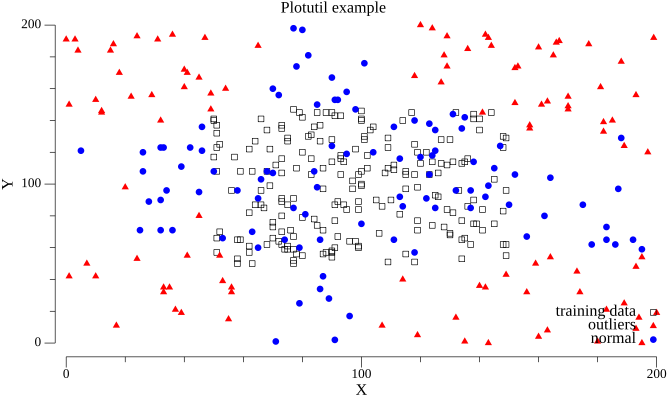

In [13]:

func XYPoints(data[][]float64) plotter.XYs {
    pts := make(plotter.XYs, len(data))
    for i, row := range data {
        n := 0
        for _, value := range row {
        if n == 0 {
        pts[i].X = value
        n = n + 1
        } else{
        pts[i].Y = value}
    }
}
    return pts
}

func GonumPlotExample(width, height int, format string) []byte {
    rand.Seed(int64(0))

    p := plot.New()

    p.Title.Text = "Plotutil example"
    p.X.Label.Text = "X"
    p.Y.Label.Text = "Y"

    //TRAINING DATA
    training, err := plotter.NewScatter(XYPoints(loadData("training.csv")))
	if err != nil {
		panic(err)
	}
	training.GlyphStyle.Color = color.RGBA{R: 0, G:0 ,B: 0, A: 255}
    training.Shape = draw.SquareGlyph{}
    if err != nil {
        panic(err)
    }

    //OUTLIERS
    outliers, err := plotter.NewScatter(XYPoints(loadData("outliers.csv")))
	if err != nil {
		panic(err)
	}
	outliers.GlyphStyle.Color = color.RGBA{R: 255, G:0 , B: 0, A: 255}
    outliers.Shape = draw.PyramidGlyph{}
    if err != nil {
        panic(err)
    }

    //NORMAL
    normal, err := plotter.NewScatter(XYPoints(loadData("normal.csv")))
	if err != nil {
		panic(err)
	}
	normal.GlyphStyle.Color = color.RGBA{R: 0, G:0 , B: 255, A: 255}
    normal.Shape = draw.CircleGlyph{}
    if err != nil {
        panic(err)
    }

    p.Add(training,outliers,normal)
    p.Legend.Add("training data", training)
    p.Legend.Add("outliers", outliers)
    p.Legend.Add("normal", normal)

	


    //Display for gonbui
    buf := bytes.NewBuffer(nil)
    writerTo, err := p.WriterTo(vg.Points(float64(width)), vg.Points(float64(height)), format)
    if err != nil {
        panic(err)
    }
    writerTo.WriteTo(buf)
    return buf.Bytes()
}

%%
gonbui.DisplayPng(GonumPlotExample(500, 300, "png"))